In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
df = pd.read_csv('pick.csv')
df.head()

,category,sku,discounted,title,price,product_url,img_url
0,Daily Needs,HAVFFSF204ING,-4%,Havells 2W Warm White LED Filament Ball Lamp E27,230,https://www.pickaboo.com/daily-need/lighting/h...,https://d1lwfjp709sq0o.cloudfront.net/media/ca...
1,Mobiles & Tablets,NOKFFS3CMPL-HP,NaN,Nokia 3,13500,https://www.pickaboo.com/mobile-tablet/mobile-...,https://d1lwfjp709sq0o.cloudfront.net/media/ca...
2,Mobiles & Tablets,ZAFN2CMPL,NaN,Nokia 2,9600,https://www.pickaboo.com/mobile-tablet/mobile-...,https://d1lwfjp709sq0o.cloudfront.net/media/ca...
3,Daily Needs,ENSWASSL30WENS,-3%,Ensysco 30 watt Solar Street Light,68040,https://www.pickaboo.com/daily-need/solar-powe...,https://d1lwfjp709sq0o.cloudfront.net/media/ca...
4,Mobiles & Tablets,WASN31CMPL,NaN,Nokia 3.1 3GB/32GB,17500,https://www.pickaboo.com/mobile-tablet/mobile-...,https://d1lwfjp709sq0o.cloudfront.net/media/ca...


In [2]:
df = df[pd.notnull(df['title'])]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8128 entries, 0 to 8127
Data columns (total 7 columns):
category       8070 non-null object
sku            8128 non-null object
discounted     3949 non-null object
title          8128 non-null object
price          8128 non-null int64
product_url    8128 non-null object
img_url        8125 non-null object
dtypes: int64(1), object(6)
memory usage: 508.0+ KB


In [4]:
col = ['category', 'title']
df = df[col]

In [5]:
df.columns

Index([u'category', u'title'], dtype='object')

In [6]:
df.columns = ['category', 'title']

In [7]:
df['category_id'] = df['category'].factorize()[0]
from io import StringIO
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [8]:
df.head()

,category,title,category_id
0,Daily Needs,Havells 2W Warm White LED Filament Ball Lamp E27,0
1,Mobiles & Tablets,Nokia 3,1
2,Mobiles & Tablets,Nokia 2,1
3,Daily Needs,Ensysco 30 watt Solar Street Light,0
4,Mobiles & Tablets,Nokia 3.1 3GB/32GB,1


In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').title.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.title).toarray()
labels = df.category_id
features.shape

(8128, 2976)

In [11]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]).encode('utf-8')))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'nan':
  . Most correlated unigrams:
       . meter
       . film
  . Most correlated bigrams:
       . cable meter
       . meter black
# 'Computers':
  . Most correlated unigrams:
       . gen
       . mouse
  . Most correlated bigrams:
       . 4gb 1tb
       . gen core
# 'Daily Needs':
  . Most correlated unigrams:
       . ingco
       . super
  . Most correlated bigrams:
       . led lux
       . super star
# 'Electronics & Appliances':
  . Most correlated unigrams:
       . siemens
       . ocean
  . Most correlated bigrams:
       . euro star
       . air conditioner
# 'Entertainment':
  . Most correlated unigrams:
       . cd
       . ps4
  . Most correlated bigrams:
       . cd playstation
       . gaming cd
# 'Fashion & Beauty':
  . Most correlated unigrams:
       . menâ
       . men
  . Most correlated bigrams:
       . al haramain
       . le reve
# 'Mobiles & Tablets':
  . Most correlated unigrams:
       . earphone
       . case
  . Most correlated bigrams:
       . x

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['title'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [13]:
df[df['title'] == "Apple Iphone 8GB"]

,category,title,category_id


In [14]:
df[df['title'] == "Razor blade"]

,category,title,category_id


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/blockchain/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/blockchain/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


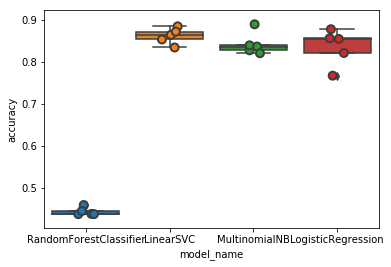

In [16]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.861598
LogisticRegression        0.835302
MultinomialNB             0.842637
RandomForestClassifier    0.444274
Name: accuracy, dtype: float64

In [18]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

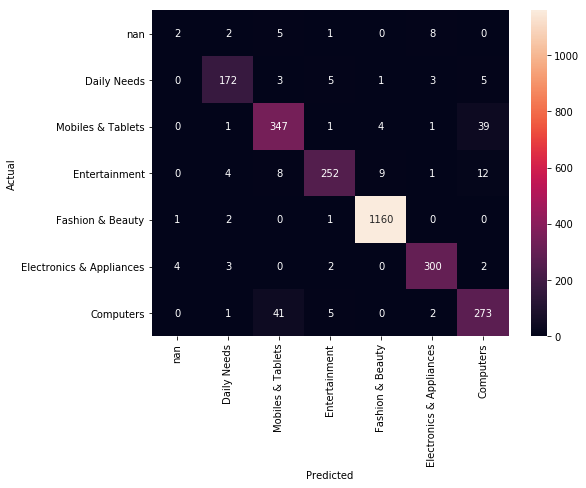

In [19]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'title']])
      print('')

'Entertainment' predicted as 'nan' : 39 examples.


,category,title



'Fashion & Beauty' predicted as 'nan' : 12 examples.


,category,title
1428,Fashion & Beauty,Xiaomi New Style Preppy Back Pack



'nan' predicted as 'Entertainment' : 41 examples.


,category,title
1771,NaN,Electric Insects Pest Killer



'Fashion & Beauty' predicted as 'Entertainment' : 8 examples.


,category,title
1282,Fashion & Beauty,Think tank Air Stream Camera Bag



'Fashion & Beauty' predicted as 'Electronics & Appliances' : 9 examples.


,category,title



'Daily Needs' predicted as 'Computers' : 8 examples.


,category,title
3906,Daily Needs,Havit (HV-SC01) Multi Socket - Grey
3900,Daily Needs,Micronet Data Socket (SP1162S-1)
7642,Daily Needs,Micronet Cable Punch Down Tool (SP1132)
7539,Daily Needs,Joyroom Mini Portable 5 Fold Umbrella (JR-CY148)
7954,Daily Needs,Joyroom Calendar Eye Protection Lamp (JR-CY165)


In [21]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [22]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'nan':
  . Top unigrams:
       . asus
       . notebook
  . Top bigrams:
       . wireless mouse
       . power supply
# 'Computers':
  . Top unigrams:
       . tv
       . kettle
  . Top bigrams:
       . ip camera
       . euro star
# 'Daily Needs':
  . Top unigrams:
       . film
       . lamp
  . Top bigrams:
       . meter black
       . iphone plus
# 'Electronics & Appliances':
  . Top unigrams:
       . men
       . bag
  . Top bigrams:
       . card holder
       . party wear
# 'Entertainment':
  . Top unigrams:
       . earphone
       . symphony
  . Top bigrams:
       . mi band
       . xiaomi amazfit
# 'Fashion & Beauty':
  . Top unigrams:
       . guitar
       . ps4
  . Top bigrams:
       . gaming chair
       . hair dryer
# 'Mobiles & Tablets':
  . Top unigrams:
       . ingco
       . scale
  . Top bigrams:
       . super star
       . freshener 300ml


In [23]:
texts = ["Nokia Phone",
         "Siccors",
         "Novel of a great man"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Nokia Phone"
  - Predicted as: 'Mobiles & Tablets'

"Siccors"
  - Predicted as: 'Fashion & Beauty'

"Novel of a great man"
  - Predicted as: 'Fashion & Beauty'

